***Мини-проект модуля MATH&ML-13: временные ряды***

***Задачи:***
- Постройть модель скользящего среднего, проанализируйте результат.
- С помощью теста Дики-Фуллера оценить стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
- Постройть модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
- Использовать интерполяцию и сэмплирование 
- Посчитать волатильность для вашего временного ряда.
- Использовать GARCH-модель для предсказания волатильности.
- Использовать линейную регрессию для получения прогноза.
- Визуализировать полученное предсказание вместе с фактическим значением.
- Сравнить результаты и сделайте выводы.
- Сделать вывод почему результат модели GARCH получился именно таким?

In [1]:
#импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
from arch import arch_model
from sklearn.linear_model import LinearRegression
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt

In [2]:
data = pd.read_csv('ghana_gdp.csv', parse_dates=["year"], index_col=["year"])

***1. Статистические модели прогнозирования***

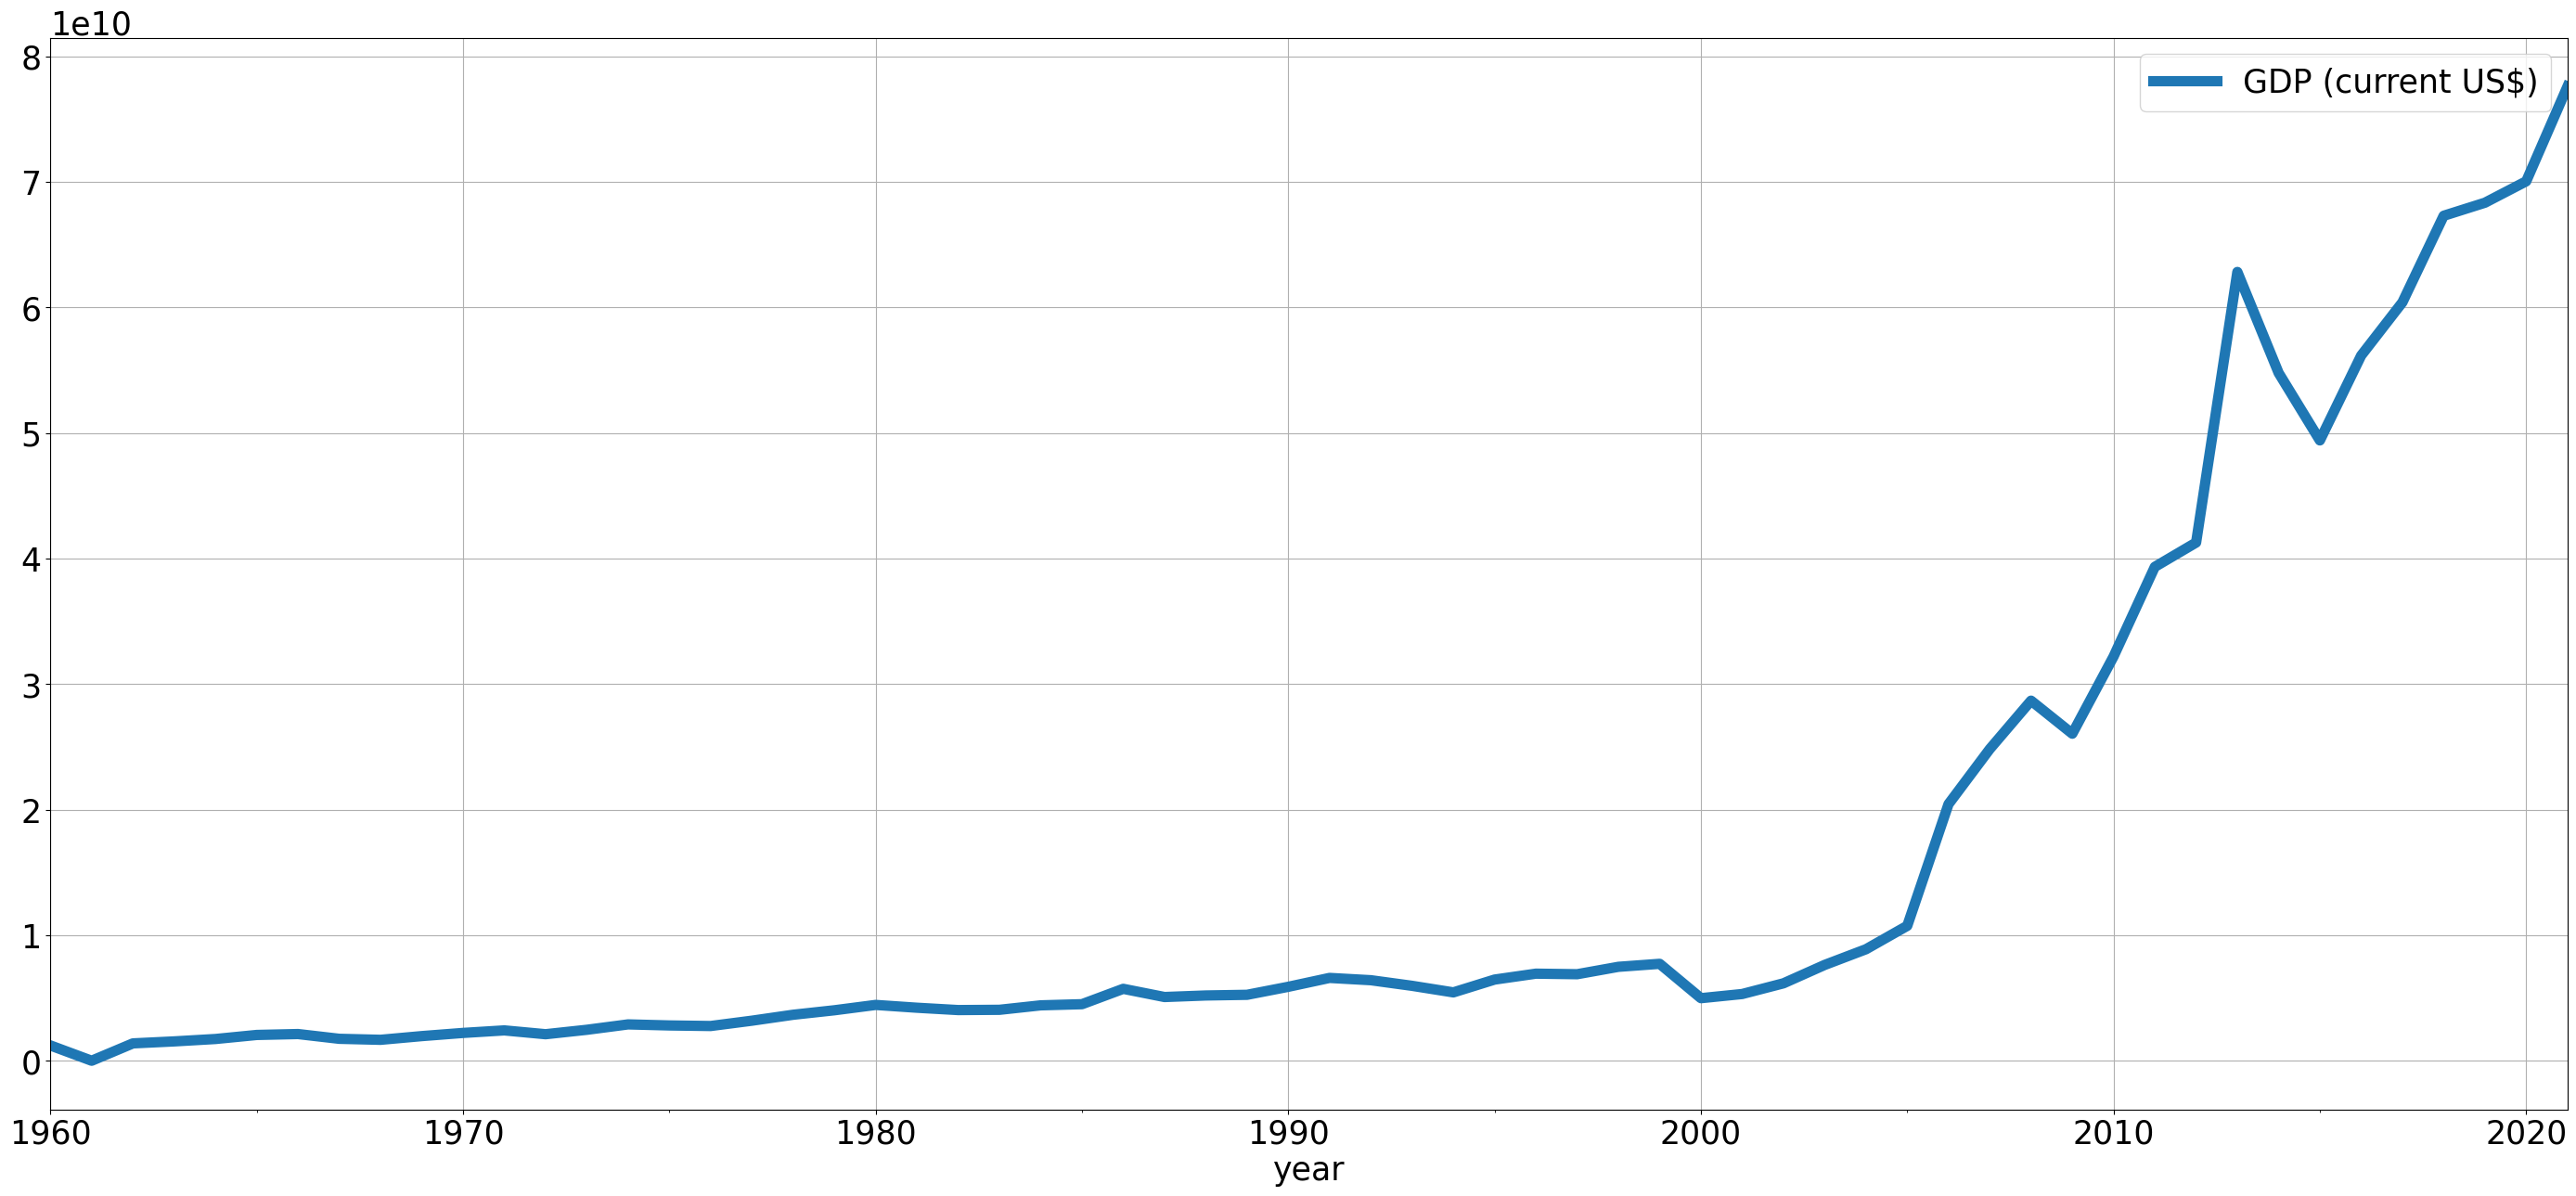

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 35, 15
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["lines.linewidth"] = 8

data.plot()
plt.grid(True)
plt.show()

Первичная оценка : при анализе исходного ряда наблюдается наличие тренда и отсутствие сезонности.

In [4]:
train,test = data[:-3].copy(), data[-3:].copy()

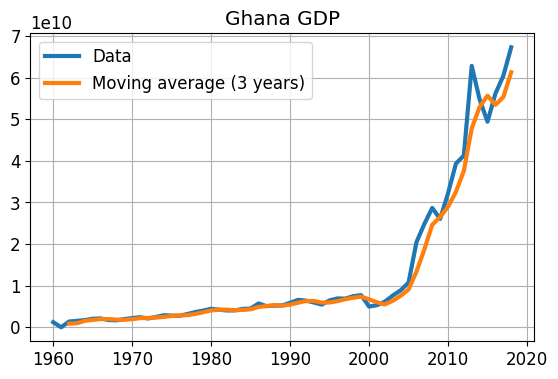

In [5]:
ma = train.rolling(3).mean()

plt.figure(figsize=(6.5, 4))
plt.rcParams["figure.figsize"] = 15, 5
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 3
plt.grid(True)
plt.plot(train, label='Data')
plt.plot(ma, label='Moving average (3 years)')
plt.title('Ghana GDP')
plt.legend();

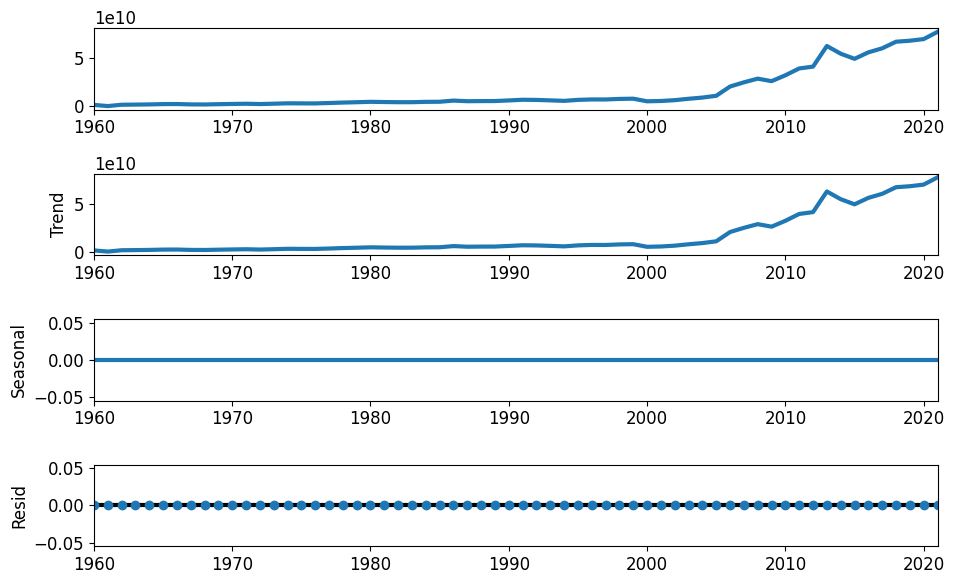

In [6]:
decomposition = seasonal_decompose(data) 
fig = decomposition.plot()
fig.set_size_inches((9.7, 6))
fig.tight_layout()

При сравнении исходного ряда с моделью скользящего среднего наблюдается "похожесть", что логично ( наличие тренда и отсутствие сезонности).

**Тест на стационарность**

In [7]:
test1 = adfuller(train["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому GDP (current US$) не являются стационарными

In [8]:
# Test for first differences
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')
# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')
# Test for third differences
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')

Statistics: -1.6702483038320777
p_value: 0.446502932971389
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

ряд нестационарен
-----------------
Statistics: -2.6408690561284898
p_value: 0.08484116917837664
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

ряд нестационарен
-----------------
Statistics: -4.779623784828512
p_value: 5.9483276402254376e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

ряд стационарен
-----------------


Временной ряд нестационарен: интегрированный ряд третьего порядка. Применяем прогноз ARIMA: авторегрессия со скользящим средним для нестационарного ряда, сезонность отсутствует

**Прогноз ARIMA**

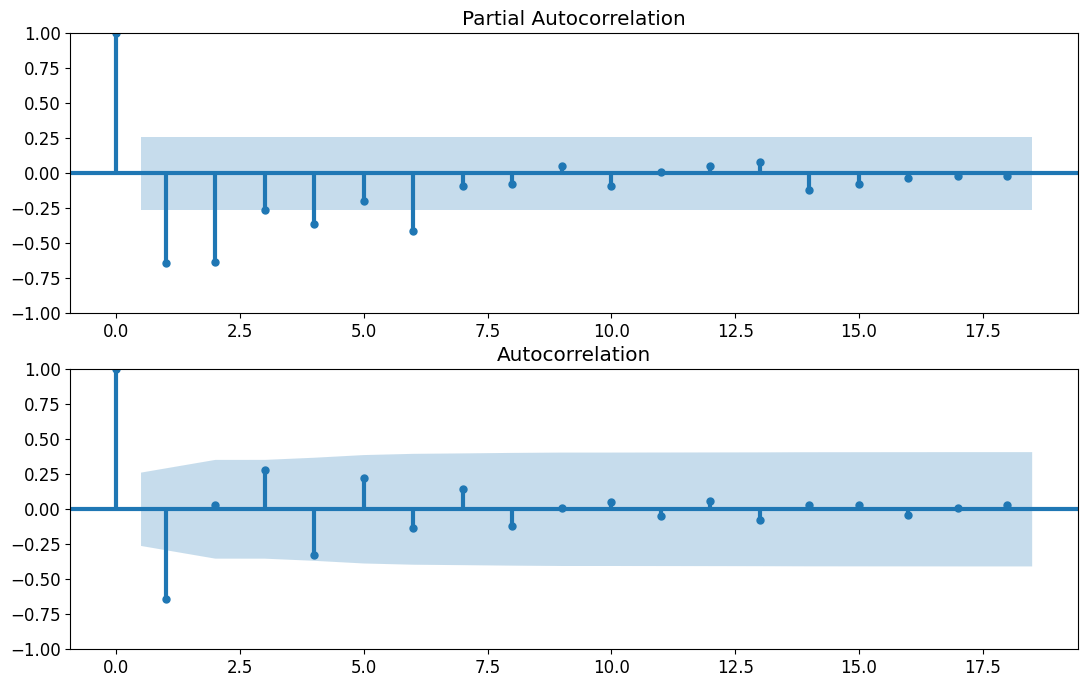

In [9]:
# Parameter selection
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

Параметры ARIMA: p = 2 (по частичной автокорреляции), d = 3 (интегрированный ряд третьего порядка), q = 1 (по автокорреляции)

In [10]:
# Model
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 15 May 2023   AIC                           2659.231
Time:                        11:46:58   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

**Побор лучших параметров с помощью pmdarima.**

- Параметр p: в диапазоне [1-6]
- Параметр q: в диапазоне [1-2]
- Оставляем интегрированный ряд третьего порядка: d=3, stationarity=False
- Задаем отсутствие сезонности: seasonal=False

In [11]:
import pmdarima as pm

In [12]:
opt_params = pmdarima.auto_arima(
    train,
    start_p=1, start_q=1,
    max_p=6, max_q=2,
    d=3, stationarity=False, seasonal=False,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.08 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.07 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.983 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 15 May 2023   AIC                           2659.231
Time:                        11:46:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

In [13]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = model_fit.predict(
    start=test.index[0], end=test.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = model_fit.get_forecast(len(test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

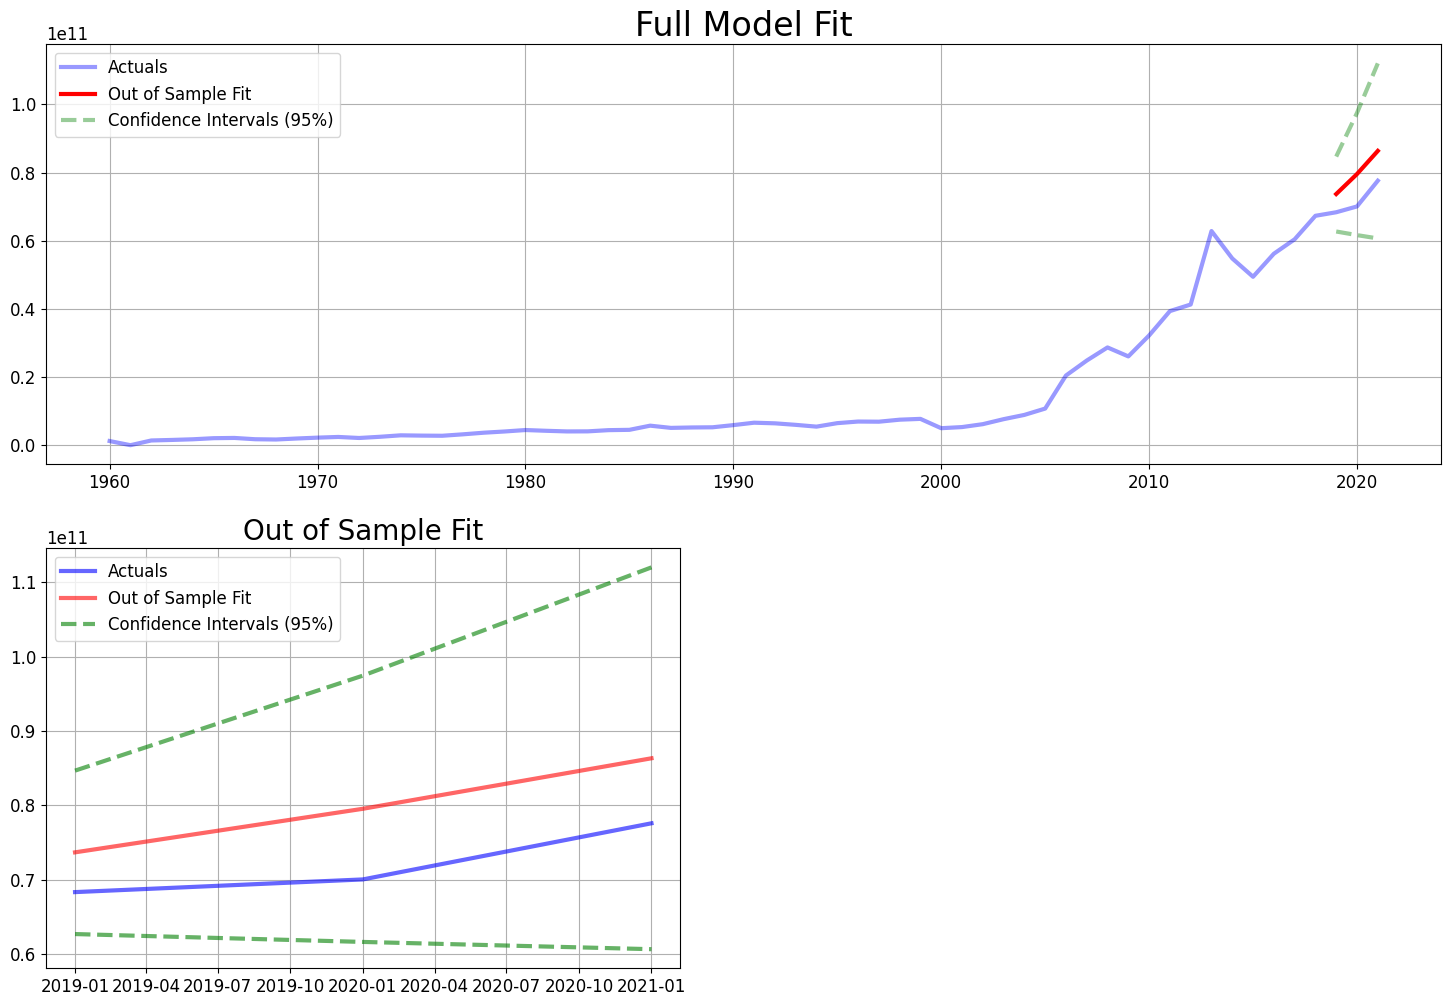

In [14]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)
plt.grid(True)
plt.plot(
    pred_df.loc[test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=20)
plt.legend()
plt.grid(True)
plt.show()

**ВЫВОД**

Построен прогноз по модели ARIMA (авторегрессия со скользящим средним для нестационарного ряда). Сезонность временного ряда отсутствует. Ошибки предсказания составляют 
, прогноз завышен. Заметно, что модель в целом ориентировалась на тренд 2014-2018 гг. и хорошо описывает его продолжение. Фактические значения не выходят за пределы 95%-го доверительного интервала.

***2. Интерполяция и сэмлирование***

**Проверка на нулевые значения**

In [15]:
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [16]:
data['GDP (current US$)'].isna().sum()

0

In [17]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

**Линейная интерполяция нулевых значений**

In [18]:
data['GDP (current US$)'].interpolate(method='linear',inplace=True)

In [19]:
train,test = data[:-3].copy(), data[-3:].copy()

**Тест на стационарность**

In [20]:
test1 = adfuller(train['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [21]:
opt_params = pmdarima.auto_arima(
    train,
    start_p=1, start_q=1,
    max_p=6, max_q=2,
    d=3, stationarity=False, seasonal=False,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.07 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.05 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.09 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.05 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.830 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 15 May 2023   AIC                           2659.226
Time:                        11:47:01   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

In [22]:
# Test for first differences
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')
# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')
# Test for third differences
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')

Statistics: -1.8255652246435998
p_value: 0.36784515276563423
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

ряд нестационарен
-----------------
Statistics: -2.634634746007842
p_value: 0.0860481372219768
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

ряд нестационарен
-----------------
Statistics: -4.825603687304014
p_value: 4.857318076800112e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

ряд стационарен
-----------------


**Прогноз ARIMA**

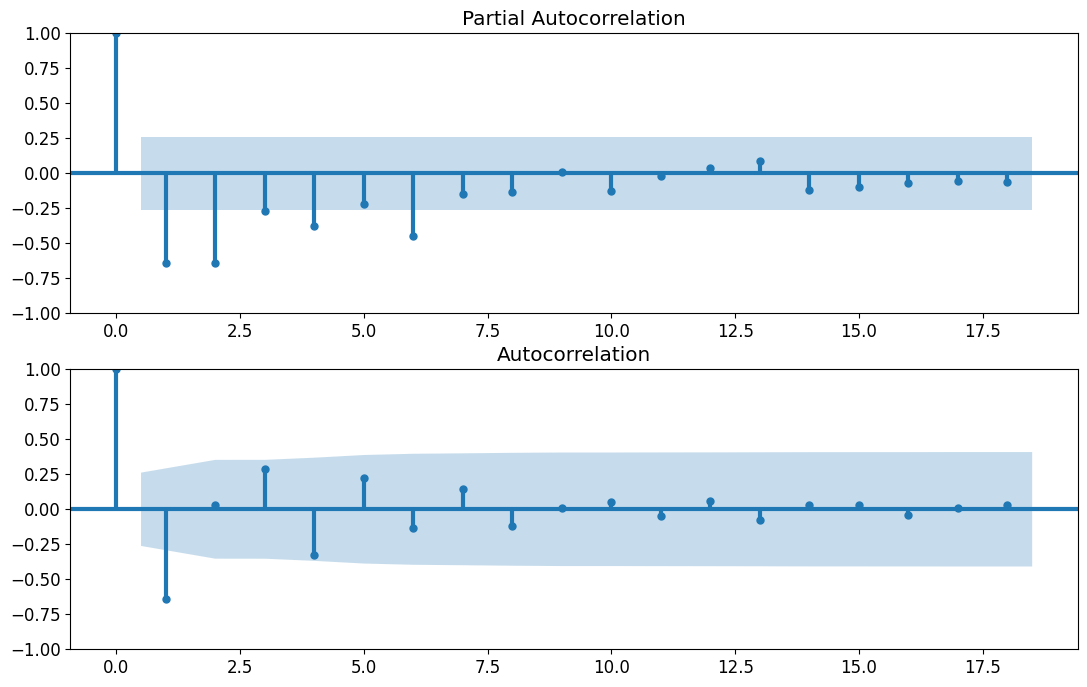

In [23]:
# Parameter selection
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

In [24]:
# Model
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Pelte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 15 May 2023   AIC                           2659.226
Time:                        11:47:02   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

**ВЫВОД**

Нулевое значение временного ряда (пропущенные данные 1961 г.) заменено на линейно интерполированное значение. Критерий Акаике (AIC) уменьшился на небольшую величину (2659.231 -> 2659.226), т.е. качество модели немного улучшилось.

***3. Гетероскедастичность***

**Волатильность**

In [25]:
vol = data.pct_change(1).mul(100).abs()[1:]

In [26]:
vol.isnull().sum()

GDP (current US$)    0
dtype: int64

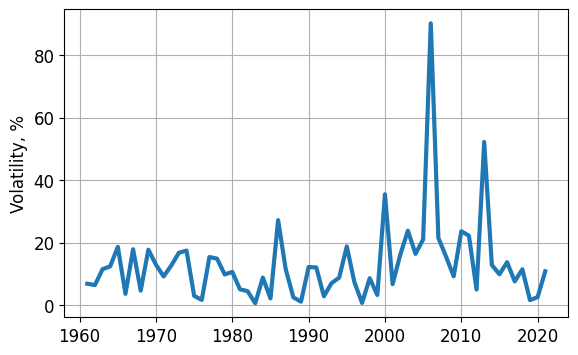

In [27]:
plt.figure(figsize=(6.5, 4))
plt.plot(vol)
plt.ylabel('Volatility, %')
plt.grid(True)
plt.show()

**Модель GARCH**

In [28]:
train, test = vol[:-3], vol[-3:]

# Augmented Dickey-Fuller unit root test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')
if aftest[0] > aftest[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
print('-----------------')

Statistics: -6.725311059553779
p_value: 3.4014596148856493e-09
Critical values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен
-----------------


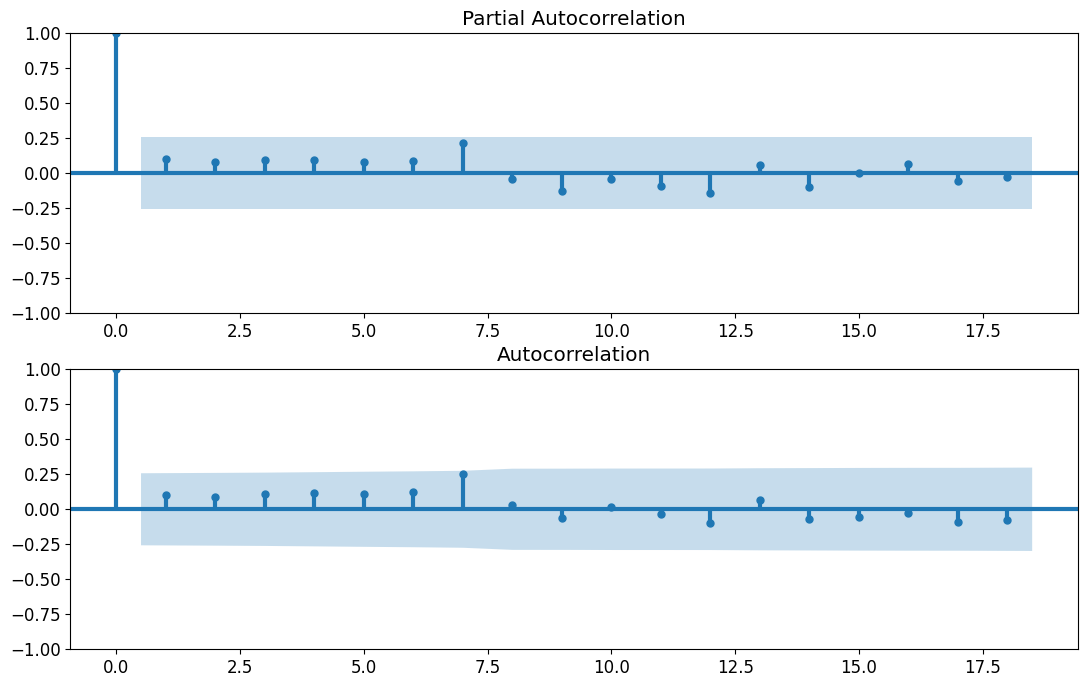

In [29]:
# Parameter selection
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(train, method='ywm', ax=ax[0])
tsaplots.plot_acf(train, ax=ax[1])
plt.show()

Автокорреляция отсутствует, выбираем минимальные параметры GARCH: p = 1, q = 1

In [30]:
model = arch_model(vol, vol='GARCH', p=1, q=1)
model_results = model.fit(last_obs=train.index[-1], update_freq=5)

garch_pred = model_results.forecast(reindex=False).variance.loc[test.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 247.95420470455127
Iteration:     10,   Func. Count:     57,   Neg. LLF: 237.6112987195586
Iteration:     15,   Func. Count:     85,   Neg. LLF: 223.50475325756761
Iteration:     20,   Func. Count:    110,   Neg. LLF: 222.86320785503517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.86320785503517
            Iterations: 20
            Function evaluations: 110
            Gradient evaluations: 20


**Линейная регрессия**

In [31]:
X_train = np.array(range(train.shape[0])).reshape(-1, 1)
y_train = train.values[:, 0]
X_test = np.array(range(
    train.shape[0], train.shape[0] + test.shape[0])).reshape(-1, 1)
y_test = test.values[:, 0]

regr = LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)
regr_pred = pd.Series(regr_pred, index=test.index)

**Сравнение результатов**

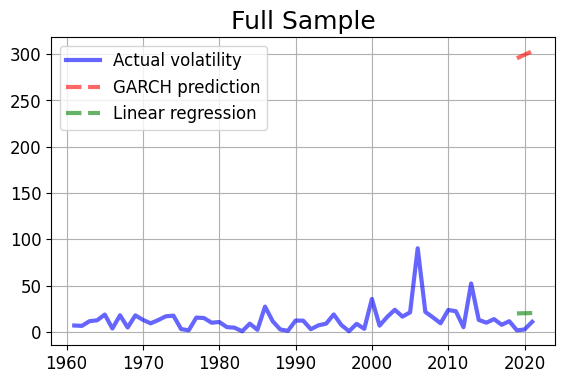

In [32]:
plt.figure(figsize=(6.5, 4))
plt.plot(vol, color='blue', label='Actual volatility', alpha=0.6)
plt.plot(garch_pred, color='red', linestyle='--', 
         label='GARCH prediction', alpha=0.6)
plt.plot(regr_pred, color='green', linestyle='--', 
         label='Linear regression', alpha=0.6)
plt.title('Full Sample', size=18)
plt.legend()
plt.grid(True)
plt.show()

***Вывод***


Модель GARCH показывает значительное расхождение с фактическими значениями волатильности. Из автокорреляционных функций видно, что автокорреляция для волатильности в представленном ряде отсутствует, т.е., вообще говоря, модель GARCH в данном случае неприменима, т.к. предыдущие значения ряда не влияют/слабо влияют на последующие. Возможно, что такая зависимость смогла бы проявиться, если бы ряд был более длинным. Простая линейная регрессия показала в данном случае более правдоподобный прогноз.